# ACO Solution

experiment parameters below can be changed to view the impact on the resulting solutions

In [107]:
#Experiment params:
M = 10
ALPHA = 1
BETA = 1
ITERATIONS = 5
E = 0.5

### Load F and D matrix from file
![alt text](problem.png "formula")
<p> Here we can see an example of F
<p> F and D are both n*n dimensions, where n=number of facilities and locations, and n=50

In [108]:
import numpy as np
import random
import math
import warnings
warnings.filterwarnings('ignore')
#np.set_printoptions(threshold=sys.maxsize)

#read data
d = open("d.txt").read().split()
f = open("f.txt").read().split()

#num of facilities and locations
n = int(math.sqrt(len(d)))

#convert to n*n matrix
D = np.reshape(d, (n, n)).T.astype(float)     #distance matrix
F = np.reshape(f, (n, n)).T.astype(float)     #flow matrix

#pad for start node
D = np.pad(D, ((1,0),(1,0)), 'constant')
F = np.pad(F, ((1,0),(1,0)), 'constant')
#create start node and asign random pheremone(0,1)
#random.seed(10)
random_d = [random.randint(1,99) for i in range(n)]
random_f = [random.randint(1,99) for i in range(n)]
#adjency matrix so start is 0 (cannot move from 0->0)
random_d.insert(0,0)
random_f.insert(0,0)

#update D and F
D[:,0] = D[0] = random_d
F[:,0] = F[0] = random_f

print(D.round(decimals=1))
print(F.round(decimals=1))

[[ 0. 34. 17. ... 42.  7.  9.]
 [34.  0. 21. ... 11. 29. 82.]
 [17. 21.  0. ... 83. 96. 74.]
 ...
 [42. 11. 83. ...  0. 94. 53.]
 [ 7. 29. 96. ... 94.  0.  6.]
 [ 9. 82. 74. ... 53.  6.  0.]]
[[ 0.  2. 38. ... 81. 14. 96.]
 [ 2.  0. 97. ... 80. 10. 78.]
 [38. 97.  0. ... 91. 45. 83.]
 ...
 [81. 80. 91. ...  0. 80. 40.]
 [14. 10. 45. ... 80.  0. 20.]
 [96. 78. 83. ... 40. 20.  0.]]


### Make numerator matrix:
![alt text](formula.png "formula")
<li> Here, a matrix consisting of the numerator of this equation is calculated. 
<li> The numerator represents: flow between universites * distance between locations
<li> Later the numerator values will be divided by the sum of neibouring numerator values to get the probability of moving

In [109]:
def compute_numerator_matrix(nm):
    #Fill P with numerator
    for x in range (len(D)):
        for y in range (len(D[x])):
            if nm[x][y] != 0 or nm[x][y] != 0.0: 
                nm[x][y] = ((F[x][y])** ALPHA) * ((F[x][y])**BETA ) 
    return nm

#probabilty matrix
numerator_matrix_global = np.ones((n+1,n+1))        #initialise dummy matrix
numerator_matrix_global = compute_numerator_matrix(numerator_matrix_global)     #populate

numerator_matrix_global

array([[0.000e+00, 4.000e+00, 1.444e+03, ..., 6.561e+03, 1.960e+02,
        9.216e+03],
       [4.000e+00, 0.000e+00, 9.409e+03, ..., 6.400e+03, 1.000e+02,
        6.084e+03],
       [1.444e+03, 9.409e+03, 0.000e+00, ..., 8.281e+03, 2.025e+03,
        6.889e+03],
       ...,
       [6.561e+03, 6.400e+03, 8.281e+03, ..., 0.000e+00, 6.400e+03,
        1.600e+03],
       [1.960e+02, 1.000e+02, 2.025e+03, ..., 6.400e+03, 0.000e+00,
        4.000e+02],
       [9.216e+03, 6.084e+03, 6.889e+03, ..., 1.600e+03, 4.000e+02,
        0.000e+00]])

### Function to update pheremones
<li> Here, a function is defined to distribute and evaporate pheremones
<li> Pheremone value will be 1/fitness, as a lower fitness is better
<li> Pheremones are spread evenly across the path: path = path + ( pheremone / len(paths[h]) )
<li> Evaporation of pheremones will be controlled by hyper parameter E

In [110]:
def update_pheremones(paths, fitnesses):
    #optain global numerator matrix
    global numerator_matrix_global

    for h in range(len(paths)):
        for i in range(len(paths[h])-1):
            x = paths[h][i]
            y= paths[h][i+1]
            pheremone = 1/fitnesses[h]
            #update numerator path between x,y with new pheremones.
            #Pheremones are spread evenly across the path: + (pheremone / len(paths[h]) )
            numerator_matrix_global[x][y] = numerator_matrix_global[x][y] + (pheremone / len(paths[h]) )
            numerator_matrix_global = compute_numerator_matrix(numerator_matrix_global)

            #evaporate with min and max pheromone quantities
            for x in range (len(numerator_matrix_global)):
                for y in range (len(numerator_matrix_global[x])):
                    if numerator_matrix_global[x][y] < 500 or numerator_matrix_global[x][y] > 100: 
                        #shrink pheromones by factor of E
                        numerator_matrix_global[x][y] = numerator_matrix_global[x][y] * E


### Main function
<p> Here, over ITERATIONS epochs, by M ants:
<ol>
<li> Neibours will be found, the current column in the ants copy of the numerator matrix will be set to 0s to prevent backtracking, and probalities of moving to each neighbour will be calculated
<li> A neighbour will be chosen to move to beased on its probablity: np.random.choice(a=len(tru_prob), p=tru_prob)
<li> The ants numerator matrix will be recomputed
<li> The next node will become the current node
<li> After the ants are done with their epoch, all paths travered by the ants will be layed with their respective pheremones
<li> Next epoch

In [111]:
import collections
import sys
import copy
import matplotlib.pyplot as plt
import statistics

av_fitnesses = []

#epoch
for q in range(ITERATIONS):
    paths = []
    fitnesses = []
    numerator_matrices = []
    # for each ant
    for z in range(M):
       
        #elite ant:
        if z == 0 and 1 > 1:
            numerator_matrix = best_ant
        else:
            #create copies for each ant
            numerator_matrix = copy.deepcopy(numerator_matrix_global)
        
        fitness = 0
        visited = []
        start = 0

        while len(visited) < n+1:
            visited.append(start)
            #get neibours from the row at numberatormatrix[start]
            neighbours = numerator_matrix[start]
            #set column to 0s to prevent backtracking
            numerator_matrix[:,start] = np.zeros(len(numerator_matrix[:,start]))
            #compute probability list of moving to neibours
            tru_prob = [i/sum(neighbours) for i in neighbours]

            #choose neighbout to travel to
            next_val = 0.0
            next = -1
            while next_val == 0.0 and next_val == 0 and next not in visited and next == -1:
                try:
                    next = np.random.choice(a=len(tru_prob), p=tru_prob)
                    next_val = tru_prob[next]
                except Exception as e:
                    break

            #compute new numerator matrix
            numerator_matrix = compute_numerator_matrix(numerator_matrix)
            
            #progress to next node
            start = next
            fitness = fitness + next_val
            
        print("Dupes: ", [item for item, count in collections.Counter(visited).items() if count > 1])
        print("visited: ", visited)
        print("fitness: ", fitness)
        
        #save path and path fitness
        paths.append(visited)
        fitnesses.append(fitness)
        numerator_matrices.append(numerator_matrix)

    print("\nAVERAGE FITNESS:", statistics.mean(fitnesses))
    #save average fitness for statistic analysis
    av_fitnesses.append(statistics.mean(fitnesses))
    
    #elitism
    min_fit = min(fitnesses)
    idx = fitnesses.index(min_fit)
    best_ant = numerator_matrices[idx]

    #update pheremones
    update_pheremones(paths, fitnesses)


Dupes:  []
visited:  [0, 29, 24, 6, 16, 26, 18, 7, 34, 37, 45, 40, 48, 36, 23, 30, 20, 47, 8, 41, 9, 27, 12, 1, 14, 43, 28, 44, 31, 49, 21, 35, 2, 13, 32, 17, 33, 38, 5, 46, 3, 50, 42, 15, 22, 25, 19, 4, 11, 39, 10]
fitness:  5.866773059500564
Dupes:  []
visited:  [0, 48, 27, 20, 30, 5, 49, 50, 1, 31, 18, 28, 37, 41, 7, 2, 44, 25, 45, 40, 19, 33, 10, 34, 24, 13, 38, 29, 35, 47, 6, 36, 39, 11, 46, 4, 8, 42, 43, 23, 15, 3, 14, 16, 17, 32, 26, 21, 9, 22, 12]
fitness:  6.351257955450615
Dupes:  []
visited:  [0, 12, 23, 44, 8, 4, 25, 13, 28, 5, 29, 37, 20, 42, 38, 41, 1, 40, 31, 43, 49, 47, 16, 22, 39, 36, 45, 11, 15, 6, 7, 33, 34, 21, 46, 3, 24, 50, 19, 35, 30, 27, 48, 9, 2, 10, 17, 18, 14, 26, 32]
fitness:  6.5581848870638595
Dupes:  []
visited:  [0, 30, 8, 4, 23, 40, 25, 36, 16, 29, 12, 34, 7, 49, 43, 48, 35, 41, 14, 42, 18, 28, 6, 37, 27, 47, 19, 32, 39, 21, 10, 33, 11, 45, 44, 5, 9, 3, 24, 22, 26, 20, 50, 2, 1, 46, 38, 15, 31, 13, 17]
fitness:  6.321450776569626
Dupes:  []
visited:  [0

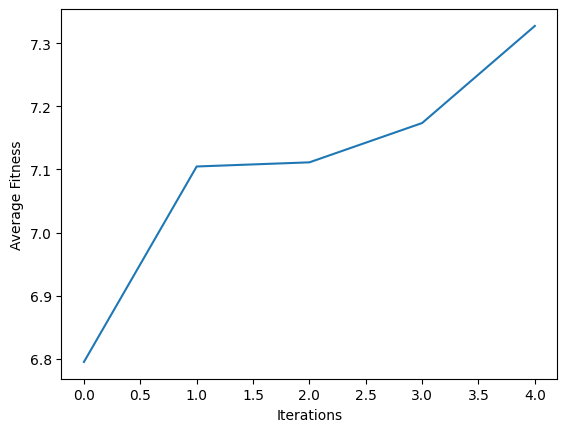

Best Path: [0, 20, 24, 13, 37, 12, 9, 45, 49, 47, 10, 31, 36, 35, 27, 16, 48, 2, 14, 17, 39, 42, 30, 41, 33, 1, 4, 25, 19, 18, 28, 11, 15, 21, 40, 46, 44, 6, 34, 38, 29, 50, 26, 8, 32, 22, 23, 43, 3, 7, 5]
Fitness:  6.950852408348838
Len: 51


In [112]:
min_fit = min(fitnesses)
idx = fitnesses.index(min_fit)
best_path = paths[idx]

plt.plot(range(0, ITERATIONS), av_fitnesses)
plt.xlabel("Iterations")
plt.ylabel("Average Fitness")
plt.show()

print("Best Path:", best_path)
print("Fitness: ", min_fit)
print("Len:", len(best_path))


## Visualisation

### Best path taken by an ant (achieved in experiment 4)

[[0, 20], [20, 42], [42, 40], [40, 4], [4, 3], [3, 33], [33, 24], [24, 29], [29, 2], [2, 28], [28, 37], [37, 44], [44, 26], [26, 15], [15, 49], [49, 47], [47, 32], [32, 17], [17, 14], [14, 31], [31, 35], [35, 27], [27, 7], [7, 18], [18, 19], [19, 8], [8, 50], [50, 43], [43, 41], [41, 21], [21, 6], [6, 34], [34, 10], [10, 13], [13, 1], [1, 46], [46, 38], [38, 12], [12, 39], [39, 30], [30, 36], [36, 9], [9, 45], [45, 11], [11, 22], [22, 5], [5, 48], [48, 25], [25, 23], [23, 16]]


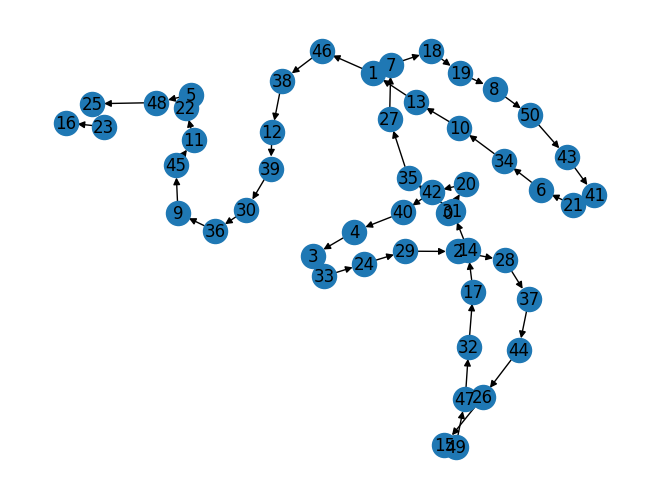

In [125]:
import networkx as nx

final_best = [0, 20, 42, 40, 4, 3,
33, 24, 29, 2, 28, 37, 44, 26, 15, 49, 47, 32, 17, 14,
31, 35, 27, 7, 18, 19, 8, 50, 43, 41, 21, 6, 34, 10,
13, 1, 46, 38, 12, 39, 30, 36, 9, 45, 11, 22, 5, 48,25, 23, 16]

l = []

for x in range (len(final_best)-1):
    l.append([final_best[x],final_best[x+1]])

print(l)

graph = nx.DiGraph()
graph.add_edges_from(l)
nx.draw(graph, with_labels = True)
plt.show()

### Construction graph of numerator matrix

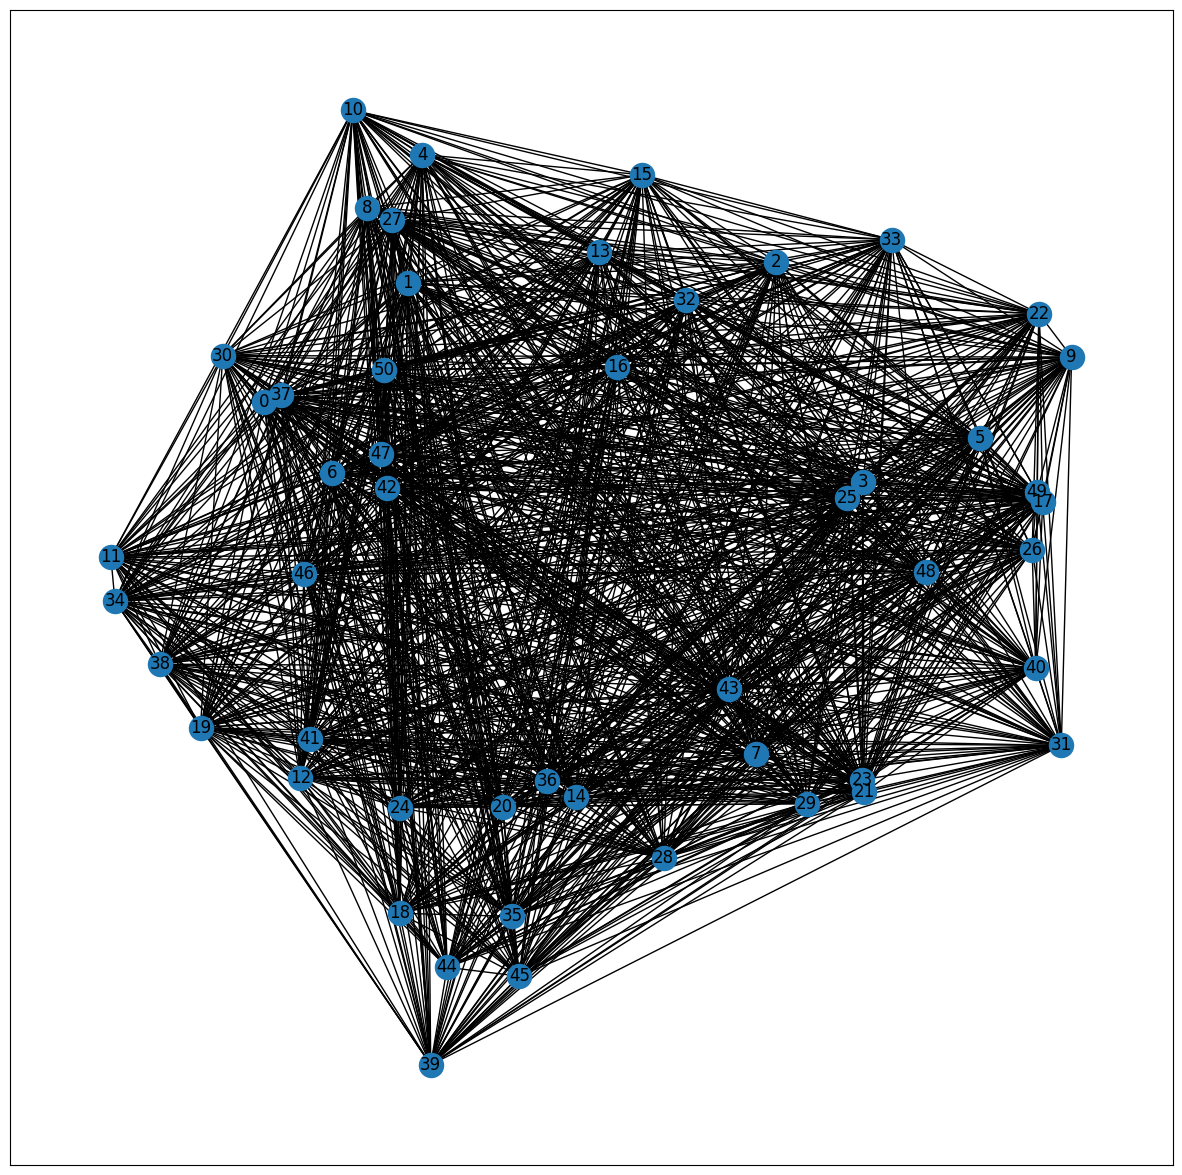

In [149]:
plt.figure(figsize=(15,15))

G = nx.from_numpy_array(numerator_matrix_global, create_using=nx.MultiGraph)
edges = G.edges(data=True)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edges)
plt.show()

#label = location
#box = facility